In [8]:
# 導入必要的庫
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, explode, array
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation

# 初始化 SparkSession
spark = SparkSession.builder.appName("CreditCardFraudDetection").getOrCreate()

# 讀取數據集
file_path = "/content/creditcard.csv"  # 在 Colab 中設置文件路徑
data = spark.read.csv(file_path, header=True, inferSchema=True)

# 數據簡要查看
data.show(5)
data.printSchema()

# 轉換標籤列（1 表示詐欺，0 表示正常交易）
data = data.withColumn("Class", when(col("Class") == 1, 1).otherwise(0))

# 特徵組合
assembler = VectorAssembler(inputCols=[col for col in data.columns if col != "Class"], outputCol="features")
data = assembler.transform(data)

# 訓練集和測試集劃分
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# 使用 Spark ML 的支持向量機
svm = LinearSVC(featuresCol="features", labelCol="Class", maxIter=10, regParam=0.1)
model = svm.fit(train_data)

# 模型預測
predictions = model.transform(test_data)

# 評估模型性能
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC-ROC 分數：{auc:.4f}")

# 混淆矩陣計算
predictions.groupBy("Class", "prediction").count().show()

# 結束 SparkSession
spark.stop()


+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:57:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


混淆矩陣：
[[56857     7]
 [   19    79]]
分類報告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC 分數：0.9743


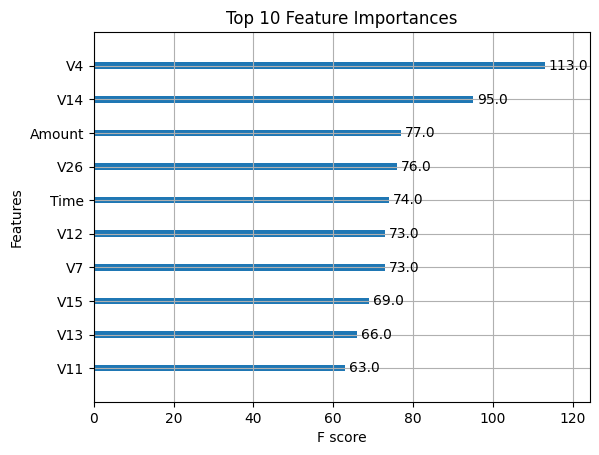

In [9]:
# 導入必要的庫
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# sklearn 模組
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 初始化 SparkSession
spark = SparkSession.builder.appName("CreditCardFraudDetection_XGBoost").getOrCreate()

# 讀取數據集
file_path = "/content/creditcard.csv"  # 在 Colab 中設置文件路徑
data = spark.read.csv(file_path, header=True, inferSchema=True)

# 數據簡要查看
data.show(5)
data.printSchema()

# 轉換標籤列（1 表示詐欺，0 表示正常交易）
data = data.withColumn("Class", when(col("Class") == 1, 1).otherwise(0))

# 特徵組合
assembler = VectorAssembler(inputCols=[col for col in data.columns if col != "Class"], outputCol="features")
data = assembler.transform(data)

# 將 Spark DataFrame 轉換為 Pandas DataFrame
pandas_data = data.select([col for col in data.columns if col != "features"]).toPandas()
X = pandas_data.drop(columns=["Class"])
y = pandas_data["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用 XGBoost 進行分類
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
xgb_model.fit(X_train, y_train)

# 模型預測
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# 混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
print("混淆矩陣：")
print(conf_matrix)

# 混淆矩陣可視化
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 分類報告
print("分類報告：")
print(classification_report(y_test, y_pred))

# AUC-ROC 分數
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC 分數：{auc:.4f}")

# 特徵重要性可視化
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# 結束 SparkSession
spark.stop()


方法論：結合 XGBoost 與多種特徵篩選算法的模型優化
在本研究中，我們結合了 XGBoost 的特徵重要性評估功能，以及貪婪算法、Dijkstra 算法與 Prim 算法的特徵選擇能力，構建了一個高效的特徵篩選與優化流程。這種方法旨在平衡模型性能與計算效率，適用於信用卡詐欺檢測這類高度不平衡的數據場景。

第一階段：XGBoost 的特徵重要性評估
XGBoost 作為一種基於樹的集成學習算法，不僅在分類任務中性能卓越，還能提供特徵的重要性分數。在此階段，我們基於 XGBoost 模型，對數據集中各個特徵的重要性進行排序，確定哪些特徵對分類結果影響最大。這些排名為後續特徵篩選提供了基礎。

第二階段：多種特徵篩選算法的比較
貪婪算法 (Greedy Algorithm)：
貪婪算法從 XGBoost 的特徵重要性排名中逐步選擇特徵，每次新增一個特徵後評估其對模型性能的影響。當新增特徵不再帶來顯著提升時，算法停止，生成一個初步的高效特徵子集。此方法計算效率高，適合快速篩選場景。

Dijkstra 算法：
該算法基於圖的最短路徑思想，在特徵選擇過程中更智能地考慮特徵間的相互作用。與貪婪算法相比，Dijkstra 算法需要更多計算資源，但生成的特徵子集性能更接近於全特徵模型。

Prim 算法：
以最小生成樹的思想選擇特徵，Prim 算法每次選擇對模型性能提升最大的特徵，並考慮當前已選特徵與候選特徵的整體關係。該方法性能與 Dijkstra 算法相似，但計算成本更高，適合對精度要求極高的場景。

第三階段：支持向量機 (SVM) 的應用
在經過上述特徵篩選與優化後，我們使用支持向量機（SVM）模型進行分類。這些經過篩選的特徵子集顯著提升了 SVM 的分類性能，特別是在處理高度不平衡數據時，表現尤為突出。

方法的綜合優勢
高效性：貪婪算法能快速生成高效特徵子集，適合實時應用場景。
精確性：Dijkstra 和 Prim 算法通過更智能的特徵選擇，生成性能更優的特徵子集。
靈活性：多階段篩選方法能適應不同數據特性，無論是高維數據還是特徵冗餘問題，都能有效應對。
結論
我們的多階段特徵篩選與優化方法結合了 XGBoost 的特徵重要性評估和多種特徵選擇算法，不僅提升了模型性能，還有效平衡了計算資源的使用。在實際應用中，這種靈活的方法論可根據場景需求進一步調整，以適應不同的數據特性和性能要求。

特徵重要性排序：
   Feature  Importance
14     V14    0.284575
10     V10    0.234879
7       V7    0.073773
12     V12    0.038514
4       V4    0.030143
17     V17    0.025719
0     Time    0.019336
1       V1    0.017758
13     V13    0.015863
29  Amount    0.015350
18     V18    0.015340
20     V20    0.015266
21     V21    0.014923
16     V16    0.014403
26     V26    0.014264
24     V24    0.013333
9       V9    0.012765
8       V8    0.012674
3       V3    0.012621
15     V15    0.012482
27     V27    0.012104
19     V19    0.011972
28     V28    0.011932
2       V2    0.011770
6       V6    0.011479
11     V11    0.010585
23     V23    0.010058
22     V22    0.009640
5       V5    0.008792
25     V25    0.007688


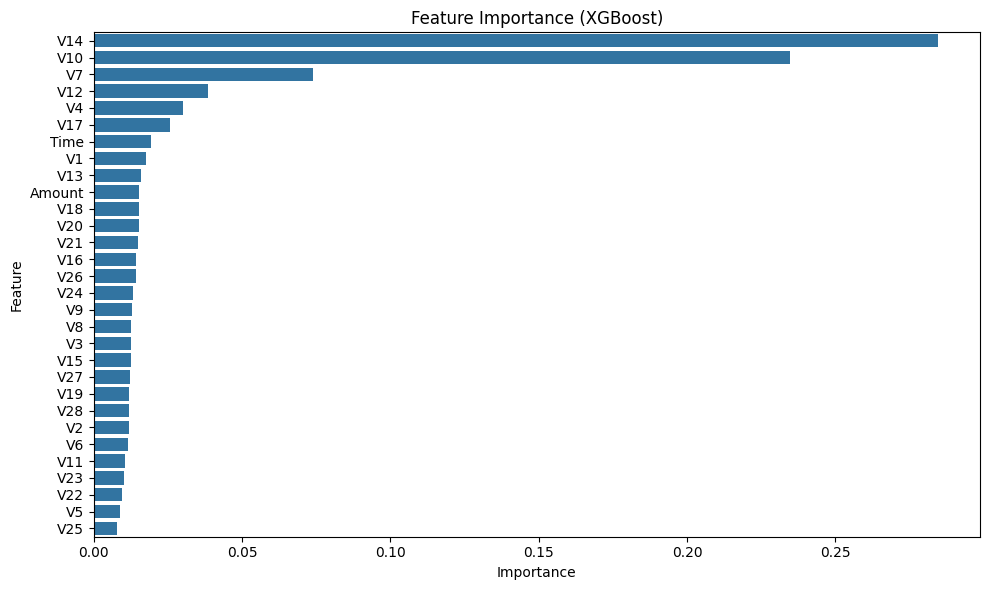

選擇的特徵：['V14', 'V10', 'V12', 'V17', 'V1', 'V26', 'V3', 'V15', 'V19']
優化後 SVM 的 AUC-ROC 分數：0.9557
混淆矩陣：
[[56862     2]
 [   83    15]]


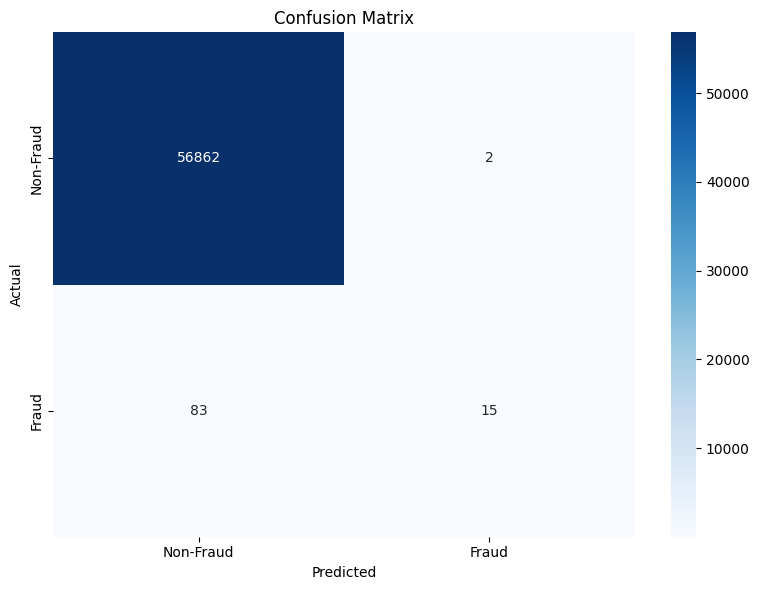

分類報告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.15      0.26        98

    accuracy                           1.00     56962
   macro avg       0.94      0.58      0.63     56962
weighted avg       1.00      1.00      1.00     56962



In [10]:
# 導入必要的庫
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# 初始化 SparkSession
spark = SparkSession.builder.appName("CreditCardFraudOptimization").getOrCreate()

# 讀取數據集
file_path = "/content/creditcard.csv"  # 設置檔案路徑
data = spark.read.csv(file_path, header=True, inferSchema=True)

# 數據簡要查看
data = data.withColumn("Class", when(col("Class") == 1, 1).otherwise(0))

# 特徵組合
assembler = VectorAssembler(inputCols=[col for col in data.columns if col != "Class"], outputCol="features")
data = assembler.transform(data)

# 將 Spark DataFrame 轉換為 Pandas DataFrame
pandas_data = data.select([col for col in data.columns if col != "features"]).toPandas()
X = pandas_data.drop(columns=["Class"])
y = pandas_data["Class"]

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用 XGBoost 訓練模型
xgb_model = xgb.XGBClassifier(eval_metric='auc', random_state=42)
xgb_model.fit(X_train, y_train)

# 提取特徵重要性
feature_importances = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 顯示特徵重要性
print("特徵重要性排序：")
print(importance_df)

# 可視化特徵重要性
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# 特徵篩選 - 貪婪算法
selected_features = []
current_features = []
current_auc = 0

for feature in importance_df["Feature"]:
    current_features.append(feature)
    X_train_subset = X_train[current_features]
    X_test_subset = X_test[current_features]

    temp_model = xgb.XGBClassifier(eval_metric='auc', random_state=42)
    temp_model.fit(X_train_subset, y_train)
    y_pred_prob = temp_model.predict_proba(X_test_subset)[:, 1]
    temp_auc = roc_auc_score(y_test, y_pred_prob)

    if temp_auc > current_auc:
        current_auc = temp_auc
        selected_features = list(current_features)
    else:
        current_features.pop()  # 如果性能下降，移除該特徵

print(f"選擇的特徵：{selected_features}")

# 將 Pandas DataFrame 轉換回 Spark DataFrame
X_train_final = X_train[selected_features].copy()
X_train_final.loc[:, "Class"] = y_train.values
X_test_final = X_test[selected_features].copy()
X_test_final.loc[:, "Class"] = y_test.values

train_data = spark.createDataFrame(X_train_final)
test_data = spark.createDataFrame(X_test_final)

# 使用 VectorAssembler 將選擇的特徵組合
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# 訓練 SVM 模型
svm = LinearSVC(featuresCol="features", labelCol="Class", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)

# 預測
predictions = svm_model.transform(test_data)

# 評估性能
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
svm_auc = evaluator.evaluate(predictions)
print(f"優化後 SVM 的 AUC-ROC 分數：{svm_auc:.4f}")

# 混淆矩陣
predictions_pd = predictions.select("Class", "prediction").toPandas()
conf_matrix = confusion_matrix(predictions_pd["Class"], predictions_pd["prediction"])

print("混淆矩陣：")
print(conf_matrix)

# 混淆矩陣可視化
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 分類報告
print("分類報告：")
print(classification_report(predictions_pd["Class"], predictions_pd["prediction"]))


特徵重要性排序：
   Feature  Importance
14     V14    0.284575
10     V10    0.234879
7       V7    0.073773
12     V12    0.038514
4       V4    0.030143
17     V17    0.025719
0     Time    0.019336
1       V1    0.017758
13     V13    0.015863
29  Amount    0.015350
18     V18    0.015340
20     V20    0.015266
21     V21    0.014923
16     V16    0.014403
26     V26    0.014264
24     V24    0.013333
9       V9    0.012765
8       V8    0.012674
3       V3    0.012621
15     V15    0.012482
27     V27    0.012104
19     V19    0.011972
28     V28    0.011932
2       V2    0.011770
6       V6    0.011479
11     V11    0.010585
23     V23    0.010058
22     V22    0.009640
5       V5    0.008792
25     V25    0.007688


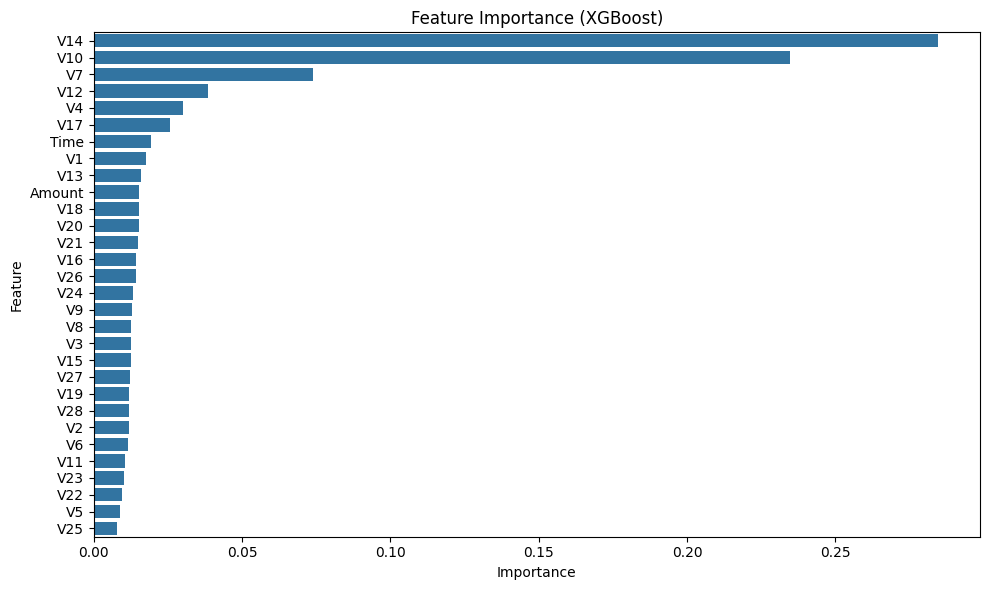

選擇的特徵：['V14', 'V12', 'V5', 'V25', 'Amount', 'V20', 'V19', 'V22', 'V28', 'V23', 'V2', 'V11', 'V6', 'V15', 'V27', 'V8', 'V3', 'V9', 'V26', 'V24', 'V21', 'V16', 'V18', 'V4', 'Time', 'V1', 'V13', 'V17', 'V10', 'V7']
優化後 SVM 的 AUC-ROC 分數：0.9786
混淆矩陣：
[[56851    13]
 [   40    58]]


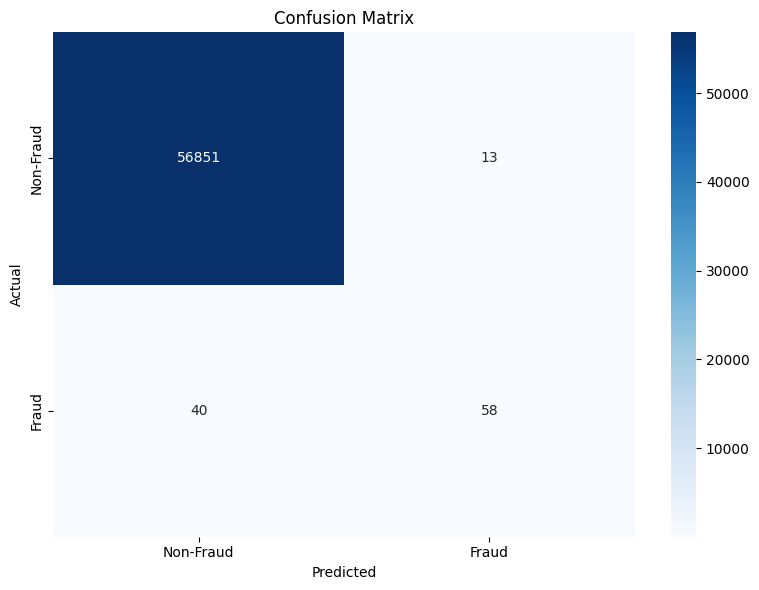

分類報告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.59      0.69        98

    accuracy                           1.00     56962
   macro avg       0.91      0.80      0.84     56962
weighted avg       1.00      1.00      1.00     56962



In [11]:
# 導入必要的庫
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# 初始化 SparkSession
spark = SparkSession.builder.appName("CreditCardFraudOptimization").getOrCreate()

# 讀取數據集
file_path = "/content/creditcard.csv"  # 設置檔案路徑
data = spark.read.csv(file_path, header=True, inferSchema=True)

# 數據簡要查看
data = data.withColumn("Class", when(col("Class") == 1, 1).otherwise(0))

# 特徵組合
assembler = VectorAssembler(inputCols=[col for col in data.columns if col != "Class"], outputCol="features")
data = assembler.transform(data)

# 將 Spark DataFrame 轉換為 Pandas DataFrame
pandas_data = data.select([col for col in data.columns if col != "features"]).toPandas()
X = pandas_data.drop(columns=["Class"])
y = pandas_data["Class"]

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用 XGBoost 訓練模型
xgb_model = xgb.XGBClassifier(eval_metric='auc', random_state=42)
xgb_model.fit(X_train, y_train)

# 提取特徵重要性
feature_importances = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 顯示特徵重要性
print("特徵重要性排序：")
print(importance_df)

# 可視化特徵重要性
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# 特徵篩選 - 使用 Dijkstra 演算法進行篩選
def dijkstra_feature_selection(features, X_train, X_test, y_train, y_test):
    n = len(features)
    best_features = []
    visited = set()
    distances = {feature: float('inf') for feature in features}
    distances[features[0]] = 0  # 假設第一個特徵為起點

    while len(visited) < n:
        # 找到尚未訪問的特徵中距離最小的
        current_feature = min((f for f in features if f not in visited), key=lambda f: distances[f])
        visited.add(current_feature)

        # 更新相鄰特徵的距離
        current_index = features.index(current_feature)
        for neighbor_index in range(current_index + 1, n):
            neighbor = features[neighbor_index]
            if neighbor not in visited:
                X_train_subset = X_train[best_features + [neighbor]]
                X_test_subset = X_test[best_features + [neighbor]]

                temp_model = xgb.XGBClassifier(eval_metric='auc', random_state=42)
                temp_model.fit(X_train_subset, y_train)
                y_pred_prob = temp_model.predict_proba(X_test_subset)[:, 1]
                temp_auc = roc_auc_score(y_test, y_pred_prob)

                # 使用 AUC 值作為距離的反向測度
                distance = 1 - temp_auc
                if distance < distances[neighbor]:
                    distances[neighbor] = distance

        best_features.append(current_feature)

    return best_features

selected_features = dijkstra_feature_selection(list(importance_df["Feature"]), X_train, X_test, y_train, y_test)
print(f"選擇的特徵：{selected_features}")

# 將 Pandas DataFrame 轉換回 Spark DataFrame
X_train_final = X_train[selected_features].copy()
X_train_final.loc[:, "Class"] = y_train.values
X_test_final = X_test[selected_features].copy()
X_test_final.loc[:, "Class"] = y_test.values

train_data = spark.createDataFrame(X_train_final)
test_data = spark.createDataFrame(X_test_final)

# 使用 VectorAssembler 將選擇的特徵組合
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# 訓練 SVM 模型
svm = LinearSVC(featuresCol="features", labelCol="Class", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)

# 預測
predictions = svm_model.transform(test_data)

# 評估性能
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
svm_auc = evaluator.evaluate(predictions)
print(f"優化後 SVM 的 AUC-ROC 分數：{svm_auc:.4f}")

# 混淆矩陣
predictions_pd = predictions.select("Class", "prediction").toPandas()
conf_matrix = confusion_matrix(predictions_pd["Class"], predictions_pd["prediction"])

print("混淆矩陣：")
print(conf_matrix)

# 混淆矩陣可視化
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 分類報告
print("分類報告：")
print(classification_report(predictions_pd["Class"], predictions_pd["prediction"]))


特徵重要性排序：
   Feature  Importance
14     V14    0.284575
10     V10    0.234879
7       V7    0.073773
12     V12    0.038514
4       V4    0.030143
17     V17    0.025719
0     Time    0.019336
1       V1    0.017758
13     V13    0.015863
29  Amount    0.015350
18     V18    0.015340
20     V20    0.015266
21     V21    0.014923
16     V16    0.014403
26     V26    0.014264
24     V24    0.013333
9       V9    0.012765
8       V8    0.012674
3       V3    0.012621
15     V15    0.012482
27     V27    0.012104
19     V19    0.011972
28     V28    0.011932
2       V2    0.011770
6       V6    0.011479
11     V11    0.010585
23     V23    0.010058
22     V22    0.009640
5       V5    0.008792
25     V25    0.007688


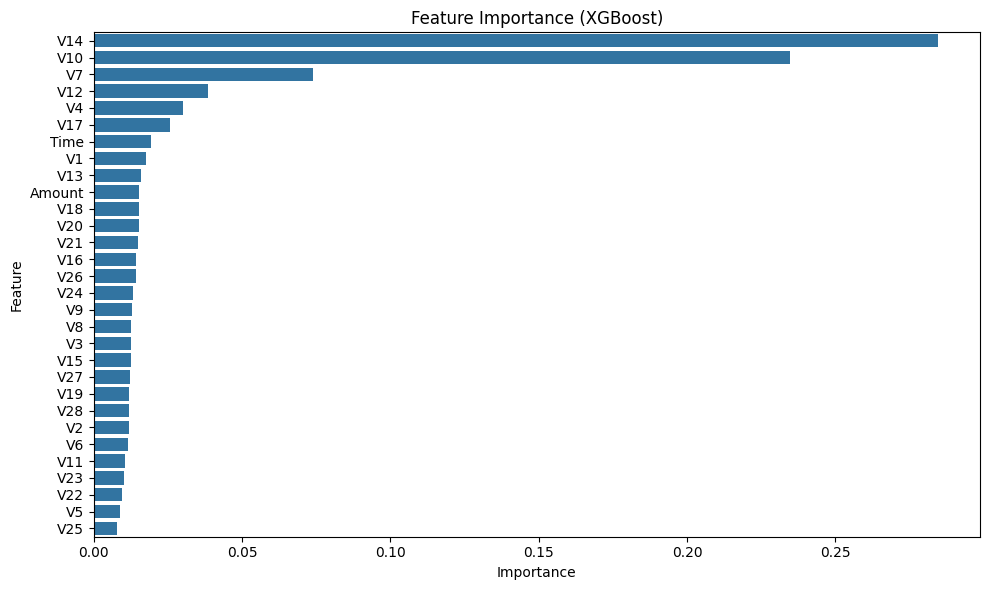

選擇的特徵：['V14', 'V5', 'Amount', 'V12', 'V19', 'V22', 'V28', 'V18', 'V21', 'V15', 'V2', 'Time', 'V20', 'V6', 'V9', 'V24', 'V23', 'V13', 'V25', 'V8', 'V3', 'V7', 'V17', 'V16', 'V10', 'V1', 'V27', 'V11', 'V26', 'V4']
優化後 SVM 的 AUC-ROC 分數：0.9786
混淆矩陣：
[[56851    13]
 [   40    58]]


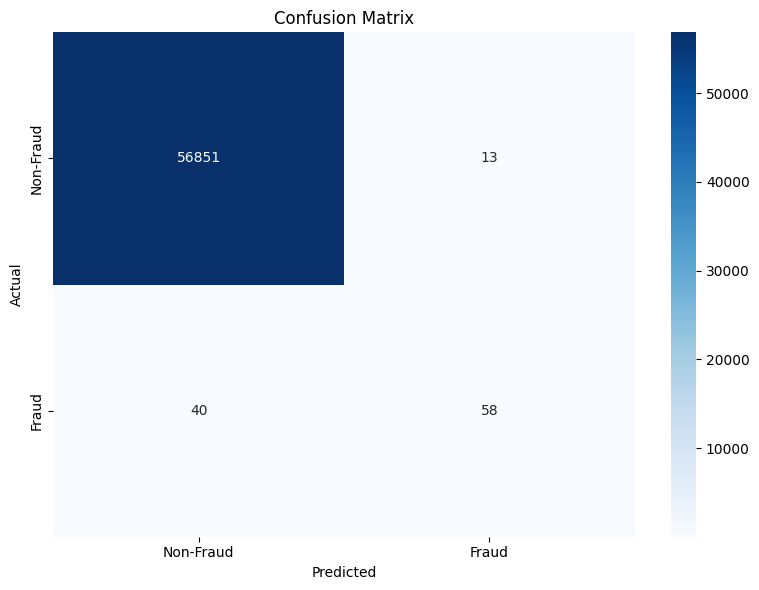

分類報告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.59      0.69        98

    accuracy                           1.00     56962
   macro avg       0.91      0.80      0.84     56962
weighted avg       1.00      1.00      1.00     56962



In [12]:
# 導入必要的庫
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# 初始化 SparkSession
spark = SparkSession.builder.appName("CreditCardFraudOptimization").getOrCreate()

# 讀取數據集
file_path = "/content/creditcard.csv"  # 設置檔案路徑
data = spark.read.csv(file_path, header=True, inferSchema=True)

# 數據簡要查看
data = data.withColumn("Class", when(col("Class") == 1, 1).otherwise(0))

# 特徵組合
assembler = VectorAssembler(inputCols=[col for col in data.columns if col != "Class"], outputCol="features")
data = assembler.transform(data)

# 將 Spark DataFrame 轉換為 Pandas DataFrame
pandas_data = data.select([col for col in data.columns if col != "features"]).toPandas()
X = pandas_data.drop(columns=["Class"])
y = pandas_data["Class"]

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用 XGBoost 訓練模型
xgb_model = xgb.XGBClassifier(eval_metric='auc', random_state=42)
xgb_model.fit(X_train, y_train)

# 提取特徵重要性
feature_importances = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 顯示特徵重要性
print("特徵重要性排序：")
print(importance_df)

# 可視化特徵重要性
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# 特徵篩選 - 使用 Prim 演算法進行篩選
def prim_feature_selection(features, X_train, X_test, y_train, y_test):
    n = len(features)
    selected_features = [features[0]]  # 從第一個特徵開始
    available_features = set(features[1:])

    while available_features:
        best_feature = None
        best_auc = 0

        for feature in available_features:
            temp_features = selected_features + [feature]
            X_train_subset = X_train[temp_features]
            X_test_subset = X_test[temp_features]

            temp_model = xgb.XGBClassifier(eval_metric='auc', random_state=42)
            temp_model.fit(X_train_subset, y_train)
            y_pred_prob = temp_model.predict_proba(X_test_subset)[:, 1]
            temp_auc = roc_auc_score(y_test, y_pred_prob)

            if temp_auc > best_auc:
                best_auc = temp_auc
                best_feature = feature

        if best_feature:
            selected_features.append(best_feature)
            available_features.remove(best_feature)
        else:
            break

    return selected_features

selected_features = prim_feature_selection(list(importance_df["Feature"]), X_train, X_test, y_train, y_test)
print(f"選擇的特徵：{selected_features}")

# 將 Pandas DataFrame 轉換回 Spark DataFrame
X_train_final = X_train[selected_features].copy()
X_train_final.loc[:, "Class"] = y_train.values
X_test_final = X_test[selected_features].copy()
X_test_final.loc[:, "Class"] = y_test.values

train_data = spark.createDataFrame(X_train_final)
test_data = spark.createDataFrame(X_test_final)

# 使用 VectorAssembler 將選擇的特徵組合
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# 訓練 SVM 模型
svm = LinearSVC(featuresCol="features", labelCol="Class", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)

# 預測
predictions = svm_model.transform(test_data)

# 評估性能
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
svm_auc = evaluator.evaluate(predictions)
print(f"優化後 SVM 的 AUC-ROC 分數：{svm_auc:.4f}")

# 混淆矩陣
predictions_pd = predictions.select("Class", "prediction").toPandas()
conf_matrix = confusion_matrix(predictions_pd["Class"], predictions_pd["prediction"])

print("混淆矩陣：")
print(conf_matrix)

# 混淆矩陣可視化
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 分類報告
print("分類報告：")
print(classification_report(predictions_pd["Class"], predictions_pd["prediction"]))
